To get to these coordinate on Google Maps, type the latitude and longitude in decimal in the search box or use:
https://www.google.com/maps/place/72%C2%B018'00.0%22S+170%C2%B013'00.1%22E/@-72.3,170.216694,17z/data=!3m1!4b1!4m2!3m1!1s0x0:0x0

<span style="color:red">HW questions</span>

1. Waiting for somebody to write a script that will do that automatically from python i.e write a script in python return the google maps url when passed with the latitude and longitudinal values of the place
2. Can you create a map where the density of points is represented as a density map (topographical map)?
3. Can you create a map that would represent, using color, the values of a chosen column (Mean, Std, V0,V1 etc.)? What conclusions can you draw from this map?


In [32]:
####This block is only copying the needed code from 02_Weather Analysis.V2 for getting the required Dataframes####
%cd /Users/phesami/Documents/DSE/phesami/DSE200/data/weather/
%pylab inline
from mpl_toolkits.basemap import Basemap, cm
import numpy as np
import matplotlib.pyplot as plt
from numpy import mean, std
from sklearn.decomposition import PCA

header=['station','measurement','year']+range(1,366)
# D=pandas.DataFrame(columns=header)
Data = pd.read_csv('SAMPLE_TMAX.csv',header=None,names=header)
G=Data.ix[:,3:368]
G[G<-400]=np.nan   #remove outliers
G[G>500]=np.nan
G=G/10   # temp / 10 is the temp in celsius
Data.ix[:,3:368]=G

def scale_temps(Din):
    matrix=Din.iloc[:,3:]
    Dout=Din.loc[:,['station','year']+range(1,366)]
    Mean=mean(matrix, axis=1).values
    Dout['Mean']=Mean
    Std= std(matrix, axis=1).values
    Dout['Std']=Std
    # Decided not to normalize each year to have mean zero and std 1
    # tmp = pd.DataFrame((matrix.values - Mean[:,np.newaxis])/Std[:,newaxis],columns=range(1,366))
    # print tmp.head()
    Dout.loc[:,3:368]=matrix.values
    return Dout
Dout=scale_temps(Data)
#reorder the columns
Dout=Dout[['station','year','Mean','Std']+range(1,366)]

M=Dout.iloc[:,3:368]
M=M.dropna(axis=0)
(columns,rows)=shape(M)
Mean=mean(M, axis=0).values

K=5
pca = PCA(n_components=K)
pca.fit(M)
T=pca.transform(M)
Tcomp=np.transpose(pca.components_)
Eig=np.matrix(Tcomp[:,:K])
#print [np.linalg.norm(U[:,i]) for i in range(k)]
matrix=np.matrix(Dout.ix[:,3:368])-Mean
matrix[isnan(matrix)]=0
Prod=matrix*Eig;

for i in range(K-1,-1,-1):
    Ser=pd.Series(np.array(Prod)[:,i],index=Dout.index)
    Dout.insert(4,'V'+str(i),Ser)
Dout.head()

# Make all lines be of length 90 to solve problem wilth read_fwf
out=open('ghcnd-stations_buffered.txt','w')
for line in open('ghcnd-stations.txt','r').readlines():
    line=line.rstrip()
    string=line+' '*(90-len(line))+'\n'
    out.write(string)
out.close()
colspecs = [(0, 11), (11, 21), (21, 31), (31, 38),(39,41),(41,72),(72,76),(76,80),(80,86)]
stations = pd.read_fwf('ghcnd-stations_buffered.txt', colspecs=colspecs, header=None, index_col=0,
                       names=['latitude','longitude','elevation','state','name','GSNFLAG','HCNFLAG','WMOID'])

lons=stations.ix[:,'longitude'].values
lats=stations.ix[:,'latitude'].values
ll=len(lons)
lonmin=-180;lonmax=180;latsmin=-80;latsmax=80;
select=(lons>lonmin) * (lons<lonmax)*(lats>latsmin)*(lats<latsmax)
lons=lons[select]
lats=lats[select]

Djoined=Dout.join(stations,on='station')

lons_Djoined=Djoined.ix[:,'longitude'].values
lats_Djoined=Djoined.ix[:,'latitude'].values

/Users/phesami/Documents/DSE/phesami/DSE200/data/weather
Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [1]:
####Part 1####
Lat=input("Enter the Latitute: \n")
Long=input("Enter the Longtitute: \n")
print "The Google Map URL for",Lat,"and",Long, "is:\n",\
 "http://maps.google.com/maps?z=12&t=m&q=loc:%f+%f"%(Lat,Long)

Enter the Latitute: 
32.718161
Enter the Longtitute: 
-117.156078
The Google Map URL for 32.718161 and -117.156078 is:
http://maps.google.com/maps?z=12&t=m&q=loc:32.718161+-117.156078


In [33]:
####Part 2####

####Creating a function to plot the density map####

def Density_Map(lons,lats):
    plt.figure(figsize=(25,15),dpi=300)
    m = Basemap(projection='merc',llcrnrlat=latsmin,urcrnrlat=latsmax,\
                llcrnrlon=lonmin,urcrnrlon=lonmax,lat_ts=20,resolution='i')
    m.drawcoastlines()

    # draw parallels and meridians.
    parallels = np.arange(-80,81,10.)
    m.drawparallels(parallels,labels=[False,True,True,False])
    meridians = np.arange(10.,351.,20.)
    m.drawmeridians(meridians,labels=[True,False,False,True])

    # convert the xs and ys to map coordinates
    xs, ys = m(lons, lats)

    m.hexbin(xs, ys, gridsize=(50,50), cmap=cm.s3pcpn)

    cbar = plt.colorbar(orientation='horizontal', shrink=0.625, aspect=20, fraction=0.2, pad=0.02)
    cbar.set_label('Number of Stations',size=18)

    plt.show()

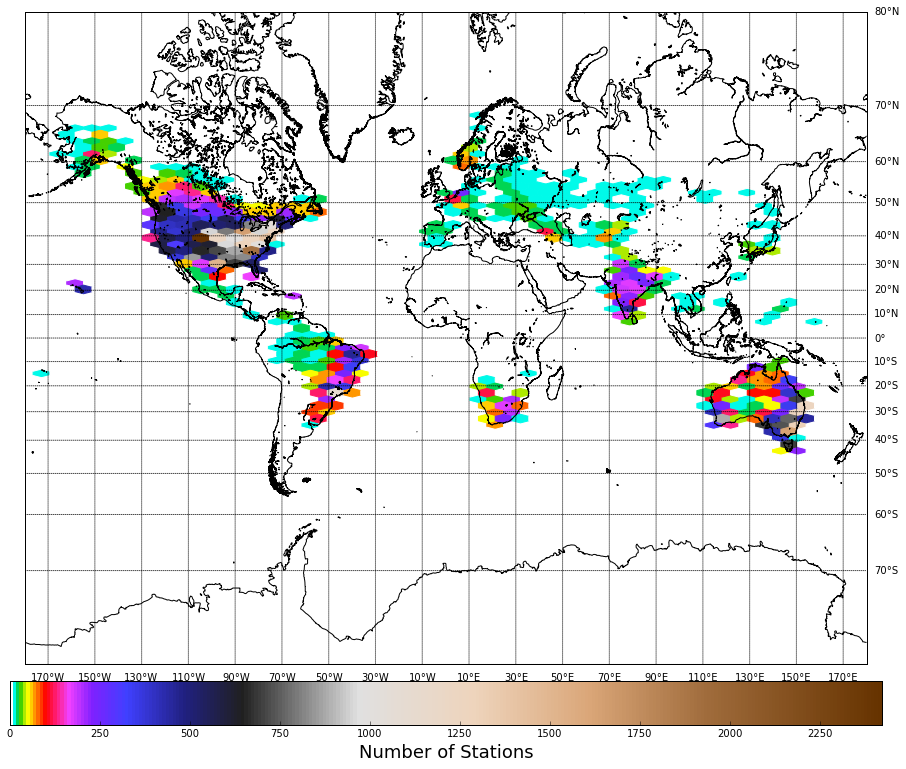

In [34]:
####plotting the density map of above lons and lats by calling the desity_Map function####
Density_Map(lons,lats)

In [35]:
####Part 3####

####Creating a function to plot a specific column####
def Spec_Col_Map (lons, lats, Column_Values, Column_Name):
    plt.figure(figsize=(25,15),dpi=300)
    m = Basemap(projection='merc',llcrnrlat=latsmin,urcrnrlat=latsmax,\
                llcrnrlon=lonmin,urcrnrlon=lonmax,lat_ts=20,resolution='i')
    m.drawcoastlines()

    # draw parallels and meridians.
    parallels = np.arange(-80,81,10.)
    m.drawparallels(parallels,labels=[False,True,True,False])
    meridians = np.arange(10.,351.,20.)
    m.drawmeridians(meridians,labels=[True,False,False,True])

    # convert the xs and ys to map coordinates
    xs, ys = m(lons_Djoined, lats_Djoined)

    m.hexbin(xs, ys, C=Column_Values, gridsize=(50,50), cmap=cm.s3pcpn)

    cbar = plt.colorbar(orientation='horizontal', shrink=0.625, aspect=20, fraction=0.2, pad=0.02)
    cbar.set_label(Column_Name,size=18)


    plt.show()



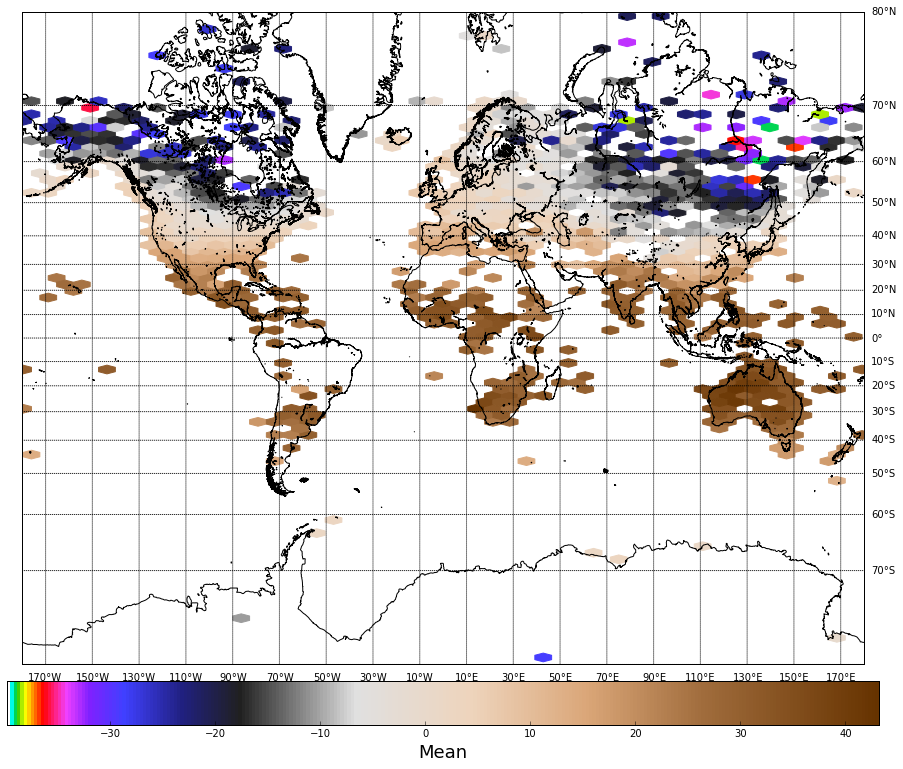

In [36]:
####plotting the map of a Mean column by calling the Spec_Col_Map function####
Mean_values=Djoined.ix[:,'Mean']
Spec_Col_Map (lons_Djoined, lats_Djoined, Mean_values, 'Mean')

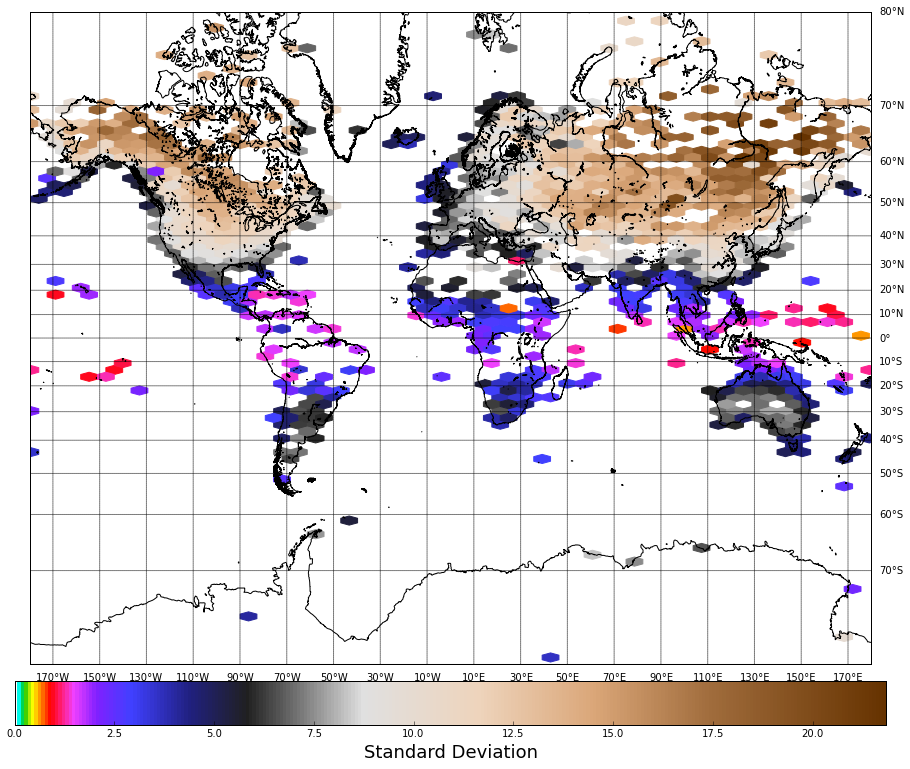

In [41]:
####plotting the map of a Std column by calling the Spec_Col_Map function####
Std_values=Djoined.ix[:,'Std']
Spec_Col_Map (lons_Djoined, lats_Djoined, Std_values, 'Standard Deviation')

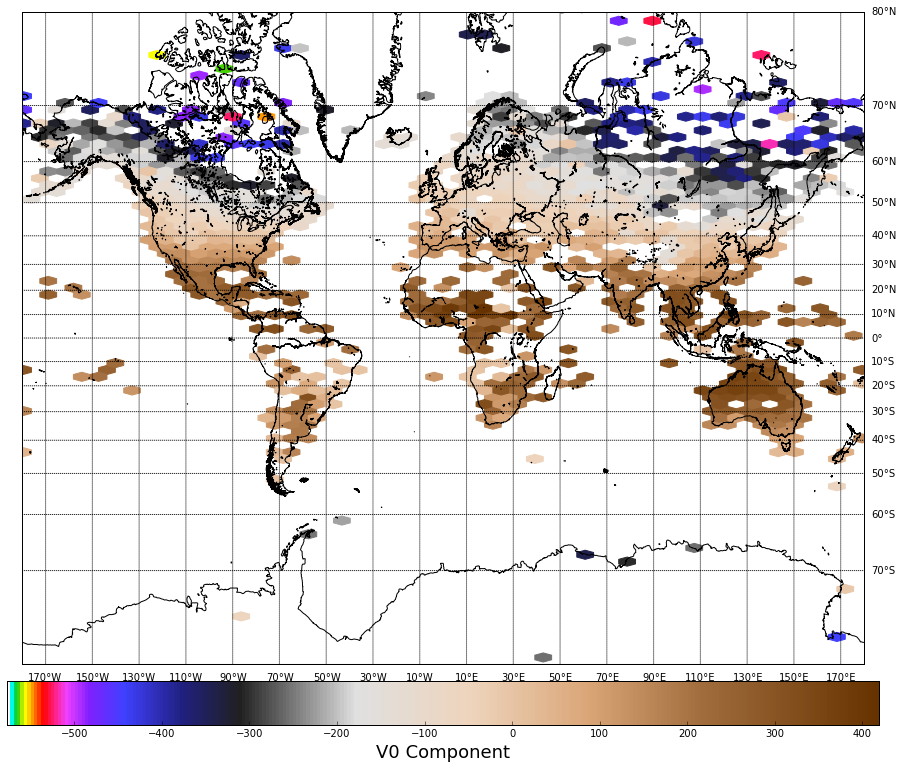

In [39]:
####plotting the map of a V0 column by calling the Spec_Col_Map function####
Std_values=Djoined.ix[:,'V0']
Spec_Col_Map (lons_Djoined, lats_Djoined, Std_values, 'V0 Component')

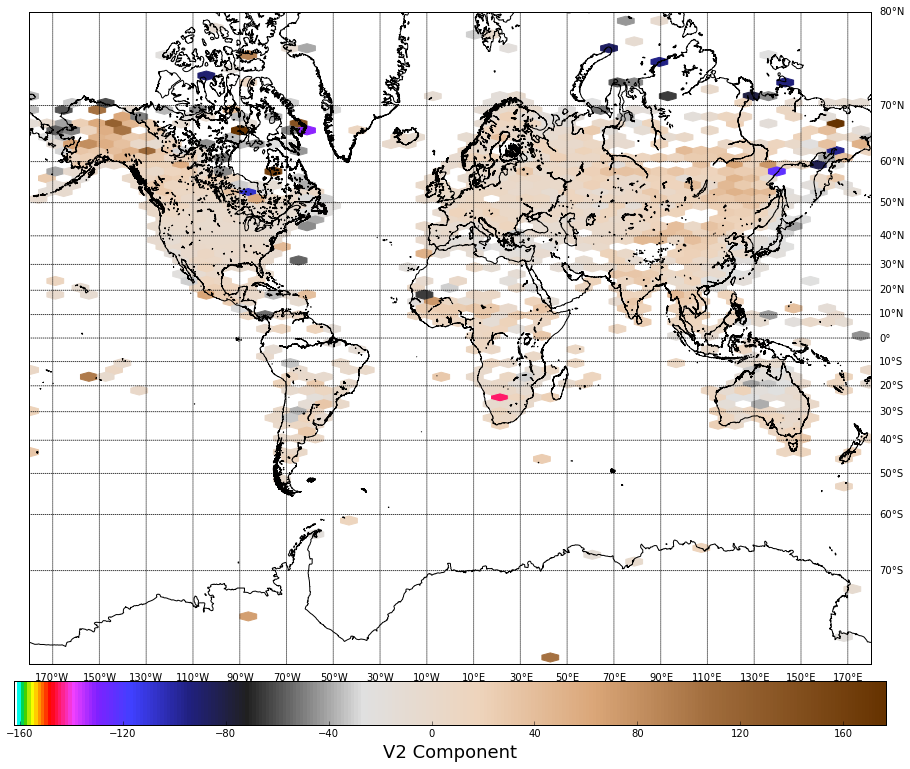

In [44]:
####plotting the map of a V4 column by calling the Spec_Col_Map function####
Std_values=Djoined.ix[:,'V2']
Spec_Col_Map (lons_Djoined, lats_Djoined, Std_values, 'V2 Component')

<span style="color:red">Conclusions drawn from above maps for density, mean, std, V0,...</span>

1. ***From density map*** it's apparent that most of the stations are located in North America and Australia with some lesser stations in South America, southern part of Africa and Asia
2. ***The Mean map*** suggests that on average the upper hemisphere is colder than lower hemisphere
3. ***The Standard Deviation map*** suggests that the upper hemisphere has larger temprature variation during the year while the lower hemisphere tends to hasve much less temprature variations. Combining this map with the mean map, it looks like that lower hemisphere is warm most of the year while upper hemisphere temprature varies widely and suggests a four season weather type with longer winters 
4. ***The V0 Component map*** suggests that the first principal component captures the same behavior as mean, i.e., suggesting the lower hemisphere is warmer thatn the upper hemisphere
4. ***The V2 Component map*** suggests a similar behavior to the variance map, i.e., higher variance in upper hemisphere compared to the lower hemisphere. It seems that V0 and V2 alone can give us a good estimate of mean and variance of the temprature during the whole year. I couldn't see any meaningfull patterns in other eigen vector values (V1,V4,...)

###Lecture3_Exercises

**Economics dataset analysis**

The folder economics (~/DSE200/DSE200/data/economics/) has a set of small datasets corresponding to different economics topics. We will use Pandas to incorporate these datasets into our workflow, merge them and analyze the economic trends as a function of time.

To achieve this, do the following

1. Read each of the csv files iteratively
2. Merge all of the data into a single dataframe by building a dictionary where the keys are the codes and the values are the Series from each downloaded file
3. Construct the Term and Default premia series using basic math on the series, and mmerge the resulting series using JOIN operation. HINT: term_premium = merged_data[’GS10’] - merged_data[’GS1’] and default_premium = merged_data[’BAA’] - merged_data[’AAA’]
4. Process the data
5. Plot ’GDP_growth’,’IP_growth’ and 'Unemp_rate' a a function of time and draw inferences
6. Use pandas function scatter_matrix to generate scatter plots of ’GDP_growth’,’IP_growth’ and 'Unemp_rate' in a mmatrix form with kernel density plots along the diagonals.

Note: Processing the data is of utmost importance for better readability and understanding of the data. Process the above data by ensuring the following

1. dropping the rows with null values
2. Output data regularly to see if they are following regular format. Use pandas.series.pct_change wherever necessary

**The codes and their corresponding series representation**

                            Series                   Code           Frequency
                            Real GDP                 GDPC1          Quarterly
                            Industrial Production   INDPRO          Quarterly
                            Core CPI               CPILFESL         Monthly
                            Unemployment Rate       UNRATE          Monthly
                            10 Year Yield            GS10           Monthly
                            1 Year Yield             GS1            Monthly
                            Baa Yield                BAA            Monthly
                            Aaa Yield                AAA            Monthly
                            
** Variable Description **

                            Series                        Description
                            Treated                       Dummy indicating whether the candidate received the treatment
                            Age                           Age in years
                            Education (years)             Years of Education
                            Black                         Dummy indicating African-American
                            Hispanic                      Dummy indicating Hispanic
                            Married                       Dummy indicating married
                            Real income Before ($)        Income before program
                        Real income After ($)         Income after program           


In [46]:
####Part 1 and Part2####
%cd ~/Documents/DSE/phesami/DSE200/data/economics/
import os
import pandas as pd
Data_Eco=pd.DataFrame(data=None,columns=['DATE'])
for files in os.listdir('.'):
    if os.path.isfile(files) and not files.endswith(".DS_Store"):
        header=['DATE',os.path.splitext(files)[0]]
        Data_Eco_tmp = pd.read_csv(files, header=None, names=header)
        Data_Eco_tmp = Data_Eco_tmp.sort(columns='DATE')
        Data_Eco=Data_Eco.merge(Data_Eco_tmp, on='DATE', how='outer')
Data_Eco=Data_Eco.iloc[:-1]
Data_Eco.head()

/Users/phesami/Documents/DSE/phesami/DSE200/data/economics


DATE   AAA   BAA CPILFESL GDPC1  GS1 GS10  INDPRO UNRATE
0  1919-01-01  5.35  7.12      NaN   NaN  NaN  NaN  4.8582    NaN
1  1919-02-01  5.35  7.20      NaN   NaN  NaN  NaN  4.6435    NaN
2  1919-03-01  5.39  7.15      NaN   NaN  NaN  NaN  4.5092    NaN
3  1919-04-01  5.44  7.23      NaN   NaN  NaN  NaN  4.5898    NaN
4  1919-05-01  5.39  7.09      NaN   NaN  NaN  NaN  4.6166    NaN

In [47]:
####Part 3####
Data_Eco['term_premium']=Data_Eco['GS10'].convert_objects(convert_numeric=True) - Data_Eco['GS1'].convert_objects(convert_numeric=True)
Data_Eco['default_premium']=Data_Eco['BAA'].convert_objects(convert_numeric=True) - Data_Eco['AAA'].convert_objects(convert_numeric=True)
Data_Eco.head()

DATE   AAA   BAA CPILFESL GDPC1  GS1 GS10  INDPRO UNRATE  \
0  1919-01-01  5.35  7.12      NaN   NaN  NaN  NaN  4.8582    NaN   
1  1919-02-01  5.35  7.20      NaN   NaN  NaN  NaN  4.6435    NaN   
2  1919-03-01  5.39  7.15      NaN   NaN  NaN  NaN  4.5092    NaN   
3  1919-04-01  5.44  7.23      NaN   NaN  NaN  NaN  4.5898    NaN   
4  1919-05-01  5.39  7.09      NaN   NaN  NaN  NaN  4.6166    NaN   

   term_premium  default_premium  
0           NaN             1.77  
1           NaN             1.85  
2           NaN             1.76  
3           NaN             1.79  
4           NaN             1.70

Populating the interactive namespace from numpy and matplotlib


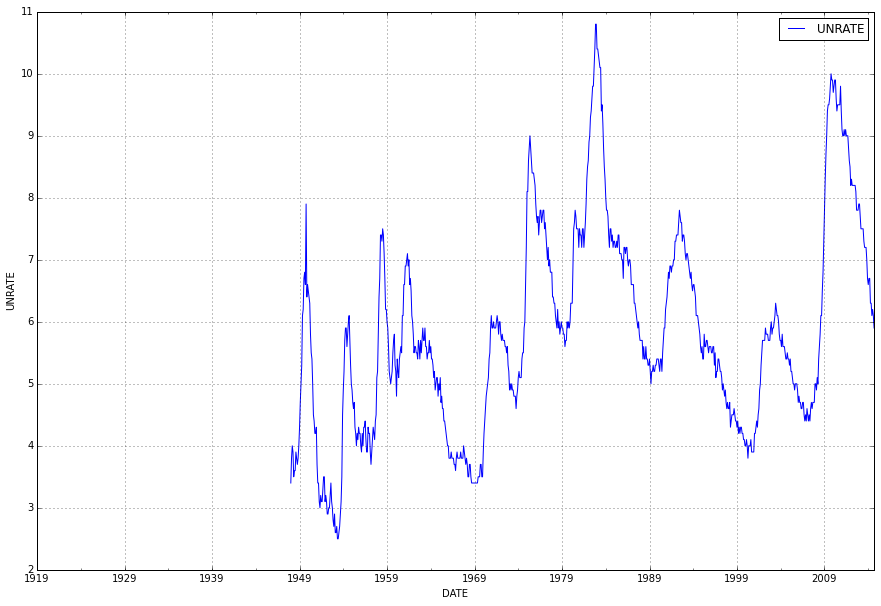

In [58]:
####Part4 and 5, dropping the rows with all NA values and plotting the Unemplyment Rate vs. Time####
import matplotlib.pyplot as plt
from pandas.tools.plotting import scatter_matrix
%pylab inline
Data_Eco.dropna(axis=0)
Data_Eco['DATE']=Data_Eco.apply(lambda x:pd.to_datetime(x))
Data_Eco['UNRATE'] = Data_Eco['UNRATE'].convert_objects(convert_numeric=True)
Data_Eco.plot(x='DATE', y='UNRATE',figsize=(15,10))
xlabel('DATE')
ylabel('UNRATE')
plt.grid(True)

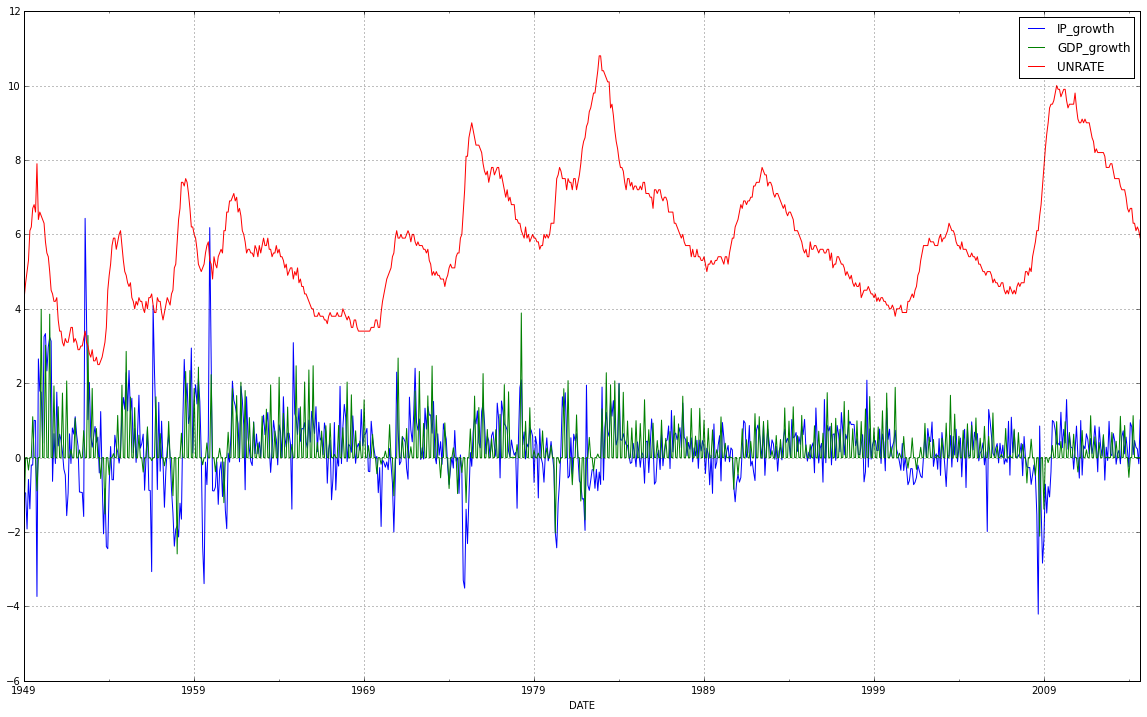

In [59]:
####Part 4 and Part 5, calculation the percent change of GDP and IP to derive GDP_Growth and IP_Growth and plot them...
#... and filling the NA using the last valid observations (pad) to count for 0 growth for the missing values####
Data_Eco['INDPRO'] = Data_Eco['INDPRO'].convert_objects(convert_numeric=True)
Data_Eco['GDPC1']=Data_Eco['GDPC1'].convert_objects(convert_numeric=True)
Data_Eco_Processed = Data_Eco.fillna(method='pad')
#Data_Eco_Processed.plot(x='DATE', y='INDPRO')
Data_Eco_Processed['IP_growth']=Data_Eco_Processed.INDPRO.pct_change()*100
Data_Eco_Processed['GDP_growth']=Data_Eco_Processed.GDPC1.pct_change()*100
####Only plotting the data after 1949 as UNRATE and GDP data is not available before 1949####
fig= Data_Eco_Processed.set_index('DATE').ix['1949-01-01':].plot( y=['IP_growth','GDP_growth','UNRATE'],figsize=(20,12))
fig.grid(True)

<span style="color:red">Conclusions drawn from above plot</span>

**GDP and IP growth seem to be strongly correlated to each other.  
Also there seems to be a strong correlation between the spikes in unemplyments rates and dips in GDP and IP growth as seen in 1954, 1957, 1976, 2008,...**

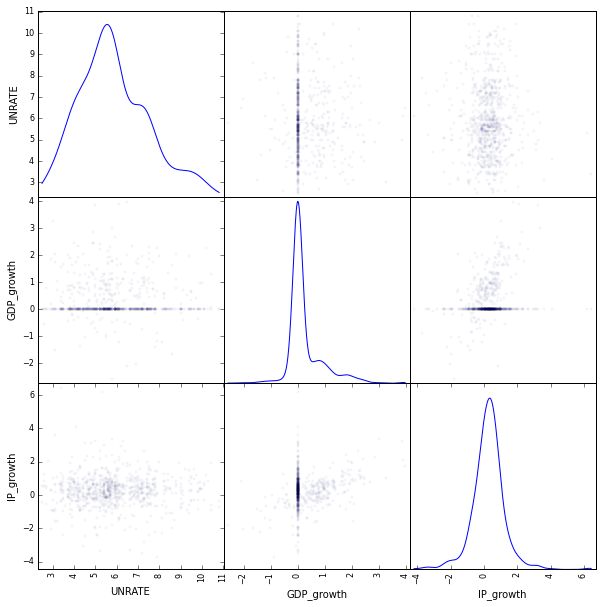

In [60]:
####Part 6####
Data_Eco_Scatter = Data_Eco_Processed.set_index('DATE').ix['1949-01-01':].ix[:,['UNRATE','GDP_growth','IP_growth']]
scatter_matrix(Data_Eco_Scatter,alpha=0.03, figsize=(10, 10), diagonal='kde');

<span style="color:red">Conclusions drawn from above scatter plots</span>

**Unemployment Rate and IP growth seems to be completely independent of each other.  
Small changes in GDP growth seems to be able to cause dramatic changes in unemployment rates**

**Nutrition dataset analysis**

Download the dataset from http://ashleyw.co.uk/files/foods-2011-10-03.json.zip
This data set is a compilation of data provided by the US department of Agriculture. The data set contains data for 6,636 unique foods and 94 unique nutrients (with an average of 56.5 nutrients per food)

Do the following

Use the built in python json module to load the food data into a python list

Your code should look like this

> import json
> db = json.load(open('foods-2011-10-03.json'))

db will be a list of 6636 python dictionaries, each containing nutritional information for a different food item. Each dictionary will have the following keys:

    1.portions
    2.description
    3.tags
    4.nutrients
    5.group
    6.id
    7.manufacture

Now, create a DataFrame of meta_data using the description, group, id, and manufacturer items in each dictionary.

Loop over db and construct a list of DataFrames containing the nutritional information for each record in db. Make sure to add a column to each of these DataFrames that contains the unique food id (id key in the dictionary)

Finally, use the pandas combining techniques to create a nutrients DataFrame. After you have done this drop duplicate entries in this DataFrame. For example, if you had named the objects nuts you would do

nuts = nuts.drop_duplicates()

Use the rename method to make sure that the description and group columns are un-ambiguous for both the meta_data DataFrame and the nutrients DataFrame (These column names are duplicated because every food has a description and group and each nutrient also has those identifiers). 

Finally, use the data combining routines to come up with a foods DataFrame containing all the meta_data and nutritional information. Make sure to do an outer style merge on the correct columns.

Using the foods DataFrame you have been building, compute the following things:

1. The food item with the highest content of each nutrient.
2. A function that accepts a nutrient name and a quantile value and generates a horizontal bar plot of the amount of that nutrient in each food group. Provide a plot title. HINT: You will need to use the quantile and sort (or order ) methods in order for this to work. 

In [62]:
%cd ~/Documents/DSE/phesami/DSE200/data/
!mkdir nutrition
%cd nutrition 
!curl -o foods-2011-10-03.json https://raw.githubusercontent.com/pydata/pydata-book/master/ch07/foods-2011-10-03.json

/Users/phesami/Documents/DSE/phesami/DSE200/data
mkdir: nutrition: File exists
/Users/phesami/Documents/DSE/phesami/DSE200/data/nutrition
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 30.3M  100 30.3M    0     0   472k      0  0:01:05  0:01:05 --:--:-- 1346k


In [63]:
import json
db = json.load(open('foods-2011-10-03.json'))

In [64]:
####Creating meta_data DataFrame####
meta_data = pd.DataFrame(db, columns=['description','group','id','manufacturer'])
meta_data.head()

description                   group    id  \
0                     Cheese, caraway  Dairy and Egg Products  1008   
1                     Cheese, cheddar  Dairy and Egg Products  1009   
2                        Cheese, edam  Dairy and Egg Products  1018   
3                        Cheese, feta  Dairy and Egg Products  1019   
4  Cheese, mozzarella, part skim milk  Dairy and Egg Products  1028   

  manufacturer  
0               
1               
2               
3               
4

In [67]:
####loopig over db and creating nutrients nuts) DataFrame---Execution of this block takes around 4 minutes####
nuts=pd.DataFrame(data=None)
for nut in db:
    nuts_tmp=pd.DataFrame(nut['nutrients'])
    nuts_tmp['id']=nut['id']
    nuts=pd.concat([nuts,nuts_tmp])
nuts.head()

description        group units   value    id
0                      Protein  Composition     g   25.18  1008
1            Total lipid (fat)  Composition     g   29.20  1008
2  Carbohydrate, by difference  Composition     g    3.06  1008
3                          Ash        Other     g    3.28  1008
4                       Energy       Energy  kcal  376.00  1008

In [68]:
####Merging meta_data and nuts and create food DataFrame####
nuts = nuts.drop_duplicates()
nuts=nuts.rename(columns={'description':'description_nutrients','group':'group_nutrients'})
foods = pd.merge(meta_data, nuts, on='id',how='outer')
foods.head()

description                   group    id manufacturer  \
0  Cheese, caraway  Dairy and Egg Products  1008                
1  Cheese, caraway  Dairy and Egg Products  1008                
2  Cheese, caraway  Dairy and Egg Products  1008                
3  Cheese, caraway  Dairy and Egg Products  1008                
4  Cheese, caraway  Dairy and Egg Products  1008                

         description_nutrients group_nutrients units   value  
0                      Protein     Composition     g   25.18  
1            Total lipid (fat)     Composition     g   29.20  
2  Carbohydrate, by difference     Composition     g    3.06  
3                          Ash           Other     g    3.28  
4                       Energy          Energy  kcal  376.00

In [71]:
####Going through each unique nutrient and creating a dictionary of the food item with the highest ...
#...content of that nutrient####
max_nutr_dict={}
for nutr in foods['description_nutrients'].unique():
    max_nutr_dict[nutr]=(foods.ix[foods['description_nutrients']==nutr].max()[0],\
                         foods.ix[foods['description_nutrients']==nutr].max()[7],\
                         foods.ix[foods['description_nutrients']==nutr].max()[6])



In [85]:
####Printing out the first 5 nutrients and the foods with the max values of these nuts, to show all nutrients...
#... remove [0:5[ at the end of max_nutr_dict.items()[0:5]####
for nutrients, values in max_nutr_dict.items()[0:5]:
    print "The food with the max",nutrients, "is:\n", values[0],"with", values[1],values[2],"\n"


The food with the max Cholesterol is:
Yogurt, vanilla, low fat, 11 grams protein per 8 ounce with 3100.0 mg 

The food with the max Caffeine is:
Yogurt, vanilla, low fat, 11 grams protein per 8 ounce with 3680.0 mg 

The food with the max Folate, food is:
Yogurt, vanilla, low fat, 11 grams protein per 8 ounce with 2340.0 mcg 

The food with the max Carbohydrate, by difference is:
Yogurt, vanilla, low fat, 11 grams protein per 8 ounce with 100.0 g 

The food with the max Serine is:
Yogurt, vanilla, low fat, 11 grams protein per 8 ounce with 4.6 g 



Populating the interactive namespace from numpy and matplotlib


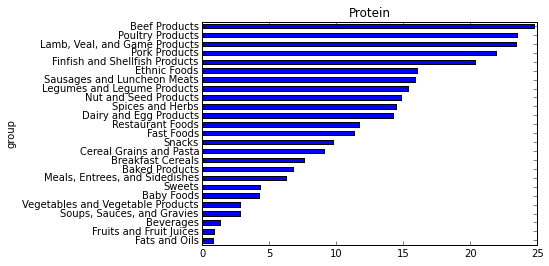

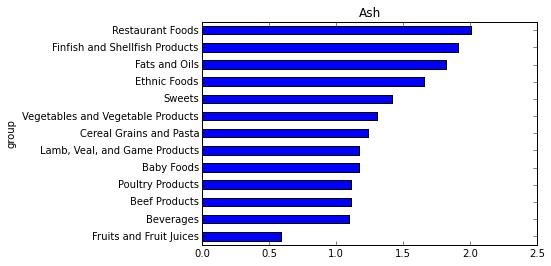

In [91]:
%pylab inline
####Writinf a function that accepts a nutrient name and a quantile value and generates a horizontal ...
#...bar plot of the amount of that nutrient in each food group. ####
def barh_plot(nutrients,Quantile):
    ####Sorting the nutrient (for better plotting), Grouping the different foods based on the food group ...
    #... and averaging the nutrient per food group to be used for plotting####
    foods_sort = foods.ix[foods['description_nutrients']==nutrients].sort(columns='group')
    foods_sort_selec=foods_sort.groupby('group').mean().sort(columns='value')
    foods_sort_selec=foods_sort_selec.ix[foods_sort_selec['value']<=foods_sort_selec['value'].quantile(Quantile)]['value']
    foods_sort_selec.plot(kind='barh')
    plt.title(nutrients)

####I used quantile to show what percentage of the foods with the specified nutrients to be plotted####
barh_plot('Protein',1)
plt.figure()
barh_plot('Ash',0.5)

**Classifying Digits**
SKLearn has many intereting datasets pre-loaded in it, one of which is load_digits (sklearn.datasets.load_digits - http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html). Load_digits is a dataset of digits, with each datapoint being a 8x8 image of a digit. 

You can load this dataset as follows

In [92]:
from sklearn.datasets import load_digits
from sklearn import tree
digits = load_digits()

And the images can be visualized as follows

1. Visualize the first 15 digits to get a better understanding of the data
2. With x as data and y as target, classify the above datasets into individual targets using a decision tree
3. Perform this classification task with sklearn.svm.SVC. How does the choice of kernel affect the results?
4. Perform this classification task with sklearn.ensemble.RandomForestClassifier. Write in the markdown below the impact each of the parammeter had on the result



        1. max_depth: 
        2. max_features:
        3. n_estimators:



Try a few sets of parameters for each model and check the F1 score (sklearn.metrics.f1_score) on your results. Output the best F1 score that you achieve. 



In [ ]:
####Part 1 ####
%pylab inline
import pylab as pl 
pl.gray() 
pl.matshow(digits.images[0]) 
pl.show()
pl.matshow(digits.images[13]) 
pl.show() 

In [349]:
####Part 2####
from sklearn import svm, metrics, datasets
####Max f2 score of 0.81 was possible only by setting a large limit for the max number of leaf####
clf_DTC=tree.DecisionTreeClassifier(max_depth=10, max_features=20,max_leaf_nodes=400)
sample_total=len(digits.data)
####deviding the data set to learning and test data set with 2/3 and 1/3 portions, respectively,...
#...and fitting the data####
clf_DTC=clf_DTC.fit(digits.data[:((sample_total*2)/3)], digits.target[:((sample_total*2)/3)])
####testing the Decision Tree using the test data (1/3 of the total data)####
expected_values = digits.target[((sample_total*2)/3):]
predicted_values = clf_DTC.predict(digits.data[((sample_total*2)/3):])
####evaluating the performance of the tree####
print "Precision, Recall, and F1 score for decision tree classifier:\n\n",\
        metrics.classification_report(expected_values, predicted_values)
print "Confusion matrix for decision tree classifier:\n\n", \
        metrics.confusion_matrix(expected_values,predicted_values)

Precision, Recall, and F1 score for decision tree classifier:

             precision    recall  f1-score   support

          0       0.95      0.92      0.93        59
          1       0.85      0.74      0.79        62
          2       0.81      0.72      0.76        60
          3       0.77      0.74      0.75        62
          4       0.85      0.84      0.85        62
          5       0.85      0.90      0.88        59
          6       0.84      0.89      0.86        61
          7       0.75      0.90      0.82        61
          8       0.68      0.71      0.70        55
          9       0.78      0.78      0.78        58

avg / total       0.82      0.81      0.81       599

Confusion matrix for decision tree classifier:

[[54  0  0  0  2  0  0  1  2  0]
 [ 0 46  3  1  0  1  2  2  5  2]
 [ 1  0 43  5  0  2  1  3  4  1]
 [ 0  1  1 46  2  4  0  3  3  2]
 [ 1  0  0  0 52  0  6  1  0  2]
 [ 1  0  0  2  0 53  1  2  0  0]
 [ 0  3  1  0  2  0 54  0  1  0]
 [ 0  0  0  0  2  0

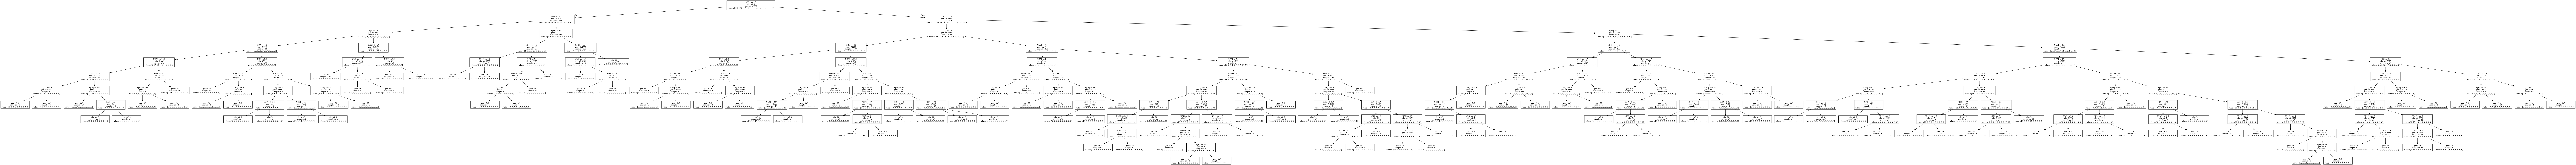

In [350]:
### visualizing the tree####
from sklearn.externals.six import StringIO
from IPython.display import Image
import pydot
dot_data = StringIO()  
tree.export_graphviz(clf_DTC, out_file=dot_data)  
graph = pydot.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png()) 

In [366]:
####Part 3, using support vector classifier instead of decision trees####
from sklearn.svm import SVC
from sklearn import svm, metrics, datasets
clf_SVC=SVC(C=1, kernel='poly', probability=True)
sample_total=len(digits.data)
####devicing the data set to learning and test data set with 2/3 and 1/3 portions, respectively, and fitting the data####
clf_SVC=clf_SVC.fit(digits.data[:((sample_total*2)/3)], digits.target[:((sample_total*2)/3)])
####testing the DT####
expected_values = digits.target[((sample_total*2)/3):]
predicted_values = clf_SVC.predict(digits.data[((sample_total*2)/3):])
####evaluating the performance of the tree####
print "Precision, Recall, and F1 score for support vector classifier:\n\n",\
        metrics.classification_report(expected_values, predicted_values)
print "Confusion matrix for support vector classifier:\n\n", \
        metrics.confusion_matrix(expected_values,predicted_values)

Precision, Recall, and F1 score for support vector classifier:

             precision    recall  f1-score   support

          0       0.97      0.97      0.97        59
          1       0.97      0.92      0.94        62
          2       1.00      0.97      0.98        60
          3       0.95      0.87      0.91        62
          4       0.98      0.95      0.97        62
          5       0.95      0.98      0.97        59
          6       0.97      0.98      0.98        61
          7       0.97      0.98      0.98        61
          8       0.87      0.96      0.91        55
          9       0.88      0.91      0.90        58

avg / total       0.95      0.95      0.95       599

Confusion matrix for support vector classifier:

[[57  0  0  0  1  0  1  0  0  0]
 [ 0 57  0  1  0  0  0  0  0  4]
 [ 1  0 58  1  0  0  0  0  0  0]
 [ 0  0  0 54  0  2  0  0  6  0]
 [ 0  0  0  0 59  0  0  0  0  3]
 [ 0  0  0  0  0 58  1  0  0  0]
 [ 0  1  0  0  0  0 60  0  0  0]
 [ 0  0  0  0  0 

In [422]:
####Part 4, using Random Forrest Classifier####
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
clf_RFC=RandomForestClassifier(n_estimators=25,max_depth=10,max_features='sqrt', criterion='entropy')
sample_total=len(digits.data)
####devicing the data set to learning and test data set with 2/3 and 1/3 portions, respectively, and fitting the data####
clf_RFC=clf_RFC.fit(digits.data[:((sample_total*2)/3)], digits.target[:((sample_total*2)/3)])
####testing the DT####
expected_values = digits.target[((sample_total*2)/3):]
predicted_values = clf_RFC.predict(digits.data[((sample_total*2)/3):])
####evaluating the performance of the tree####
print "Precision, Recall, and F1 score for Random Forrest classifier:\n\n",\
        metrics.classification_report(expected_values, predicted_values)
print "Confusion matrix for Random Forrest classifier:\n\n", \
        metrics.confusion_matrix(expected_values,predicted_values)

Precision, Recall, and F1 score for Random Forrest classifier:

             precision    recall  f1-score   support

          0       0.98      0.98      0.98        59
          1       0.93      0.82      0.87        62
          2       1.00      0.90      0.95        60
          3       0.88      0.81      0.84        62
          4       0.98      0.95      0.97        62
          5       0.89      0.98      0.94        59
          6       0.98      1.00      0.99        61
          7       0.95      1.00      0.98        61
          8       0.85      0.93      0.89        55
          9       0.83      0.90      0.86        58

avg / total       0.93      0.93      0.93       599

Confusion matrix for Random Forrest classifier:

[[58  0  0  0  1  0  0  0  0  0]
 [ 0 51  0  2  0  1  0  0  0  8]
 [ 1  1 54  3  0  0  0  0  0  1]
 [ 0  1  0 50  0  2  0  1  8  0]
 [ 0  0  0  0 59  0  0  2  0  1]
 [ 0  0  0  0  0 58  1  0  0  0]
 [ 0  0  0  0  0  0 61  0  0  0]
 [ 0  0  0  0  0 

<span style="color:red">Best f1 Scores from above scatter plots</span>

1. **Decision Tree Classifier**: 0.81 using max_depth=10, max_features=20,max_leaf_nodes=400
2. **Support Vector Classifier**: 0.95 using kernel='poly', all other kernel functions gives inferior results, also as the model doesn't seem to be overfitting there are wasn't much room to play with other paramateres (like C) to improve the performance
3. **Random forrest Classifier**: 0.93 using n_estimators=25,max_depth=10,max_features='sqrt', criterion='entropy'. max_feature f Log2 and sqrt was giving the best results while using Gaussian (rbf) gave the worst results. Reducing the number of estimators less than 25 worsen the results. Reducing the max_depth less than 10 also degrades the performance while increasing them wasn't giving much gain but most likely would cause overfitting if tested on other test sets.


**Dimensionality Reduction - PCA**

Principal Component Analysis is a very powerful unsupervised method for dimensionality reduction in data. 

Apply dimensionality reduction technique PCA (Principle Component Analysis) on the prev dataset - load_digits(). 
Use the sklearn inbuilt tool sklearn.decomposition.PCA

Print the shape of the matrix before and after the application of PCA on the dataset. Using variance, analyze the ammount of information thrown away and plot the variance(cumulative) against the number of components  

Try other dimensionality reduction techniques - sklearn.decomposition.RandomizedPCA, sklearn.decomposition.FastICA  as well 
(this extended analysis need not be submitted as part of homework)


(1797, 64)
(1797, 20)


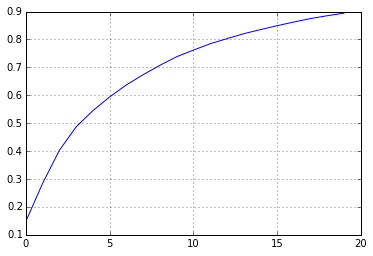

In [424]:
###Applying PCA on the digits dataset and analyzing the amount of information thrown away####
from sklearn.decomposition import PCA
pca=PCA(n_components=20, whiten=False)
print shape(digits.data)
pca.fit(digits.data)
data=pca.transform(digits.data)
print shape(data)
cumulative_explained = cumsum(pca.explained_variance_ratio_) 
plot(cumulative_explained);
grid()


***It seems that using around 18 of the 64 features (28% of the features) we can conserve 90% of the data variance***

(1797, 64)
(1797, 20)


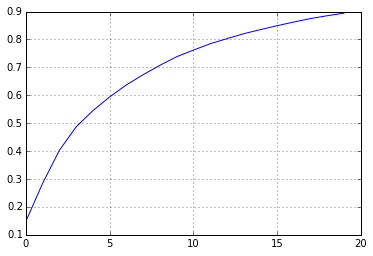

In [433]:
####Using RandomizedPCA instead of PCA####
from sklearn.decomposition import RandomizedPCA
ran_pca=RandomizedPCA(n_components=20, whiten=True, iterated_power=5, random_state=10)
print shape(digits.data)
ran_pca.fit(digits.data)
data=ran_pca.transform(digits.data)
print shape(data)
cumulative_explained = cumsum(pca.explained_variance_ratio_) 
plot(cumulative_explained);
grid()


(1797, 64)
(1797, 20)


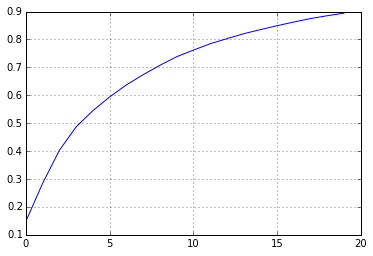

In [436]:
####Using FastICA instead of PCA####
from sklearn.decomposition import FastICA
ran_fica=FastICA(n_components=20, max_iter=50)
print shape(digits.data)
ran_fica.fit(digits.data)
data=ran_fica.transform(digits.data)
print shape(data)
cumulative_explained = cumsum(pca.explained_variance_ratio_) 
plot(cumulative_explained);
grid()


***It seems that the amount of data preserved using FastICA and RandmozedPCA is the same as legacy PCA***